In [1]:
from plotnine import *
import pandas as pd
import numpy as np

In [2]:
# time = "2024-03-29_04:53"
time = "2024-03-29_07:23"
time = "2024-03-31_15:54"
time = "2024-03-31_16:37"
time = "2024-03-31_17:12"
time = "2024-04-01_15:42"
time = "2024-04-01_17:06"
time = "2024-04-01_18:11"
time = "2024-04-16_16:47"
time = "2024-04-18_19:23"
time = "2024-04-18_20:30"
time = "2024-04-19_01:29"
time = "2024-04-19_09:39"
time = "2024-05-19_16:34"
time = "2024-05-19_16:58"
time = "2024-05-19_17:38"
time = "2024-05-19_18:55"
time = "2024-05-20_04:15"
time = "2024-05-20_10:30"


df = pd.read_csv(f"/projects/genomic-ml/da2343/ml_project_2/unsupervised/kmeans/results/{time}_results.csv")

# df['test_cumsum_annualized_return'] = df['test_cumsum_annualized_return'] * -1
# remove where dist_measure is 2
# remove where future_candles is 5
# remove where n_clusters is 150 or 200
# remove where log_return_threshold is greater than 0.01
# remove where calmar_ratio_threshold is not 2

# df = df[df["dist_measure"] != 2]
# df = df[df["window"] < 5]
# df = df[df["random_state"] == 42]
# df = df[df["test_size"] == 2880]
# df = df[df["algorithm"] == "kmeans"]
# df = df[(df["test_negative_sharpe_ratio"] >= 1) | (df["test_sharpe_ratio"] >= 1)]
df = df[(df["test_negative_sharpe_ratio"] >= 0.15) | (df["test_sharpe_ratio"] >= 0.15)]

df

,window,train_sum_annualized_return,train_sum_actual_return,train_n_trades,test_sum_annualized_return,test_sum_actual_return,test_n_trades,train_cumsum_annualized_return,train_cumsum_actual_return,train_sharpe_ratio,test_cumsum_annualized_return,test_cumsum_actual_return,test_sharpe_ratio,test_negative_sharpe_ratio,max_k_labels,n_clusters,algorithm,train_size,test_size,random_state
55578,0,1.02,102,227,-1.400000e-01,-14,62,1.02,102,3.147236,-0.14,-14,-0.207665,0.159066,5,100,gaussian_mixture,2880,960,4
55579,1,0.93,93,177,1.110223e-16,0,68,1.95,195,3.147236,-0.14,-14,-0.207665,0.159066,5,100,gaussian_mixture,2880,960,4
55580,2,1.82,182,276,-5.700000e-01,-57,73,3.77,377,3.147236,-0.71,-71,-0.207665,0.159066,5,100,gaussian_mixture,2880,960,4
55581,3,0.98,98,200,1.500000e-01,15,67,4.75,475,3.147236,-0.56,-56,-0.207665,0.159066,5,100,gaussian_mixture,2880,960,4
55582,4,1.22,122,204,2.700000e-01,27,53,5.97,597,3.147236,-0.29,-29,-0.207665,0.159066,5,100,gaussian_mixture,2880,960,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764235,124,1.87,187,335,-2.700000e-01,-27,58,216.21,21621,2.915434,-8.73,-873,-0.206447,0.159102,5,100,gaussian_mixture,3840,960,100
764236,125,1.17,117,280,-3.500000e-01,-35,58,217.38,21738,2.915434,-9.08,-908,-0.206447,0.159102,5,100,gaussian_mixture,3840,960,100
764237,126,1.74,174,458,-8.300000e-01,-83,120,219.12,21912,2.915434,-9.91,-991,-0.206447,0.159102,5,100,gaussian_mixture,3840,960,100
764238,127,1.22,122,331,2.000000e-02,2,80,220.34,22034,2.915434,-9.89,-989,-0.206447,0.159102,5,100,gaussian_mixture,3840,960,100


/projects/genomic-ml/da2343/cs685/lib/python3.9/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


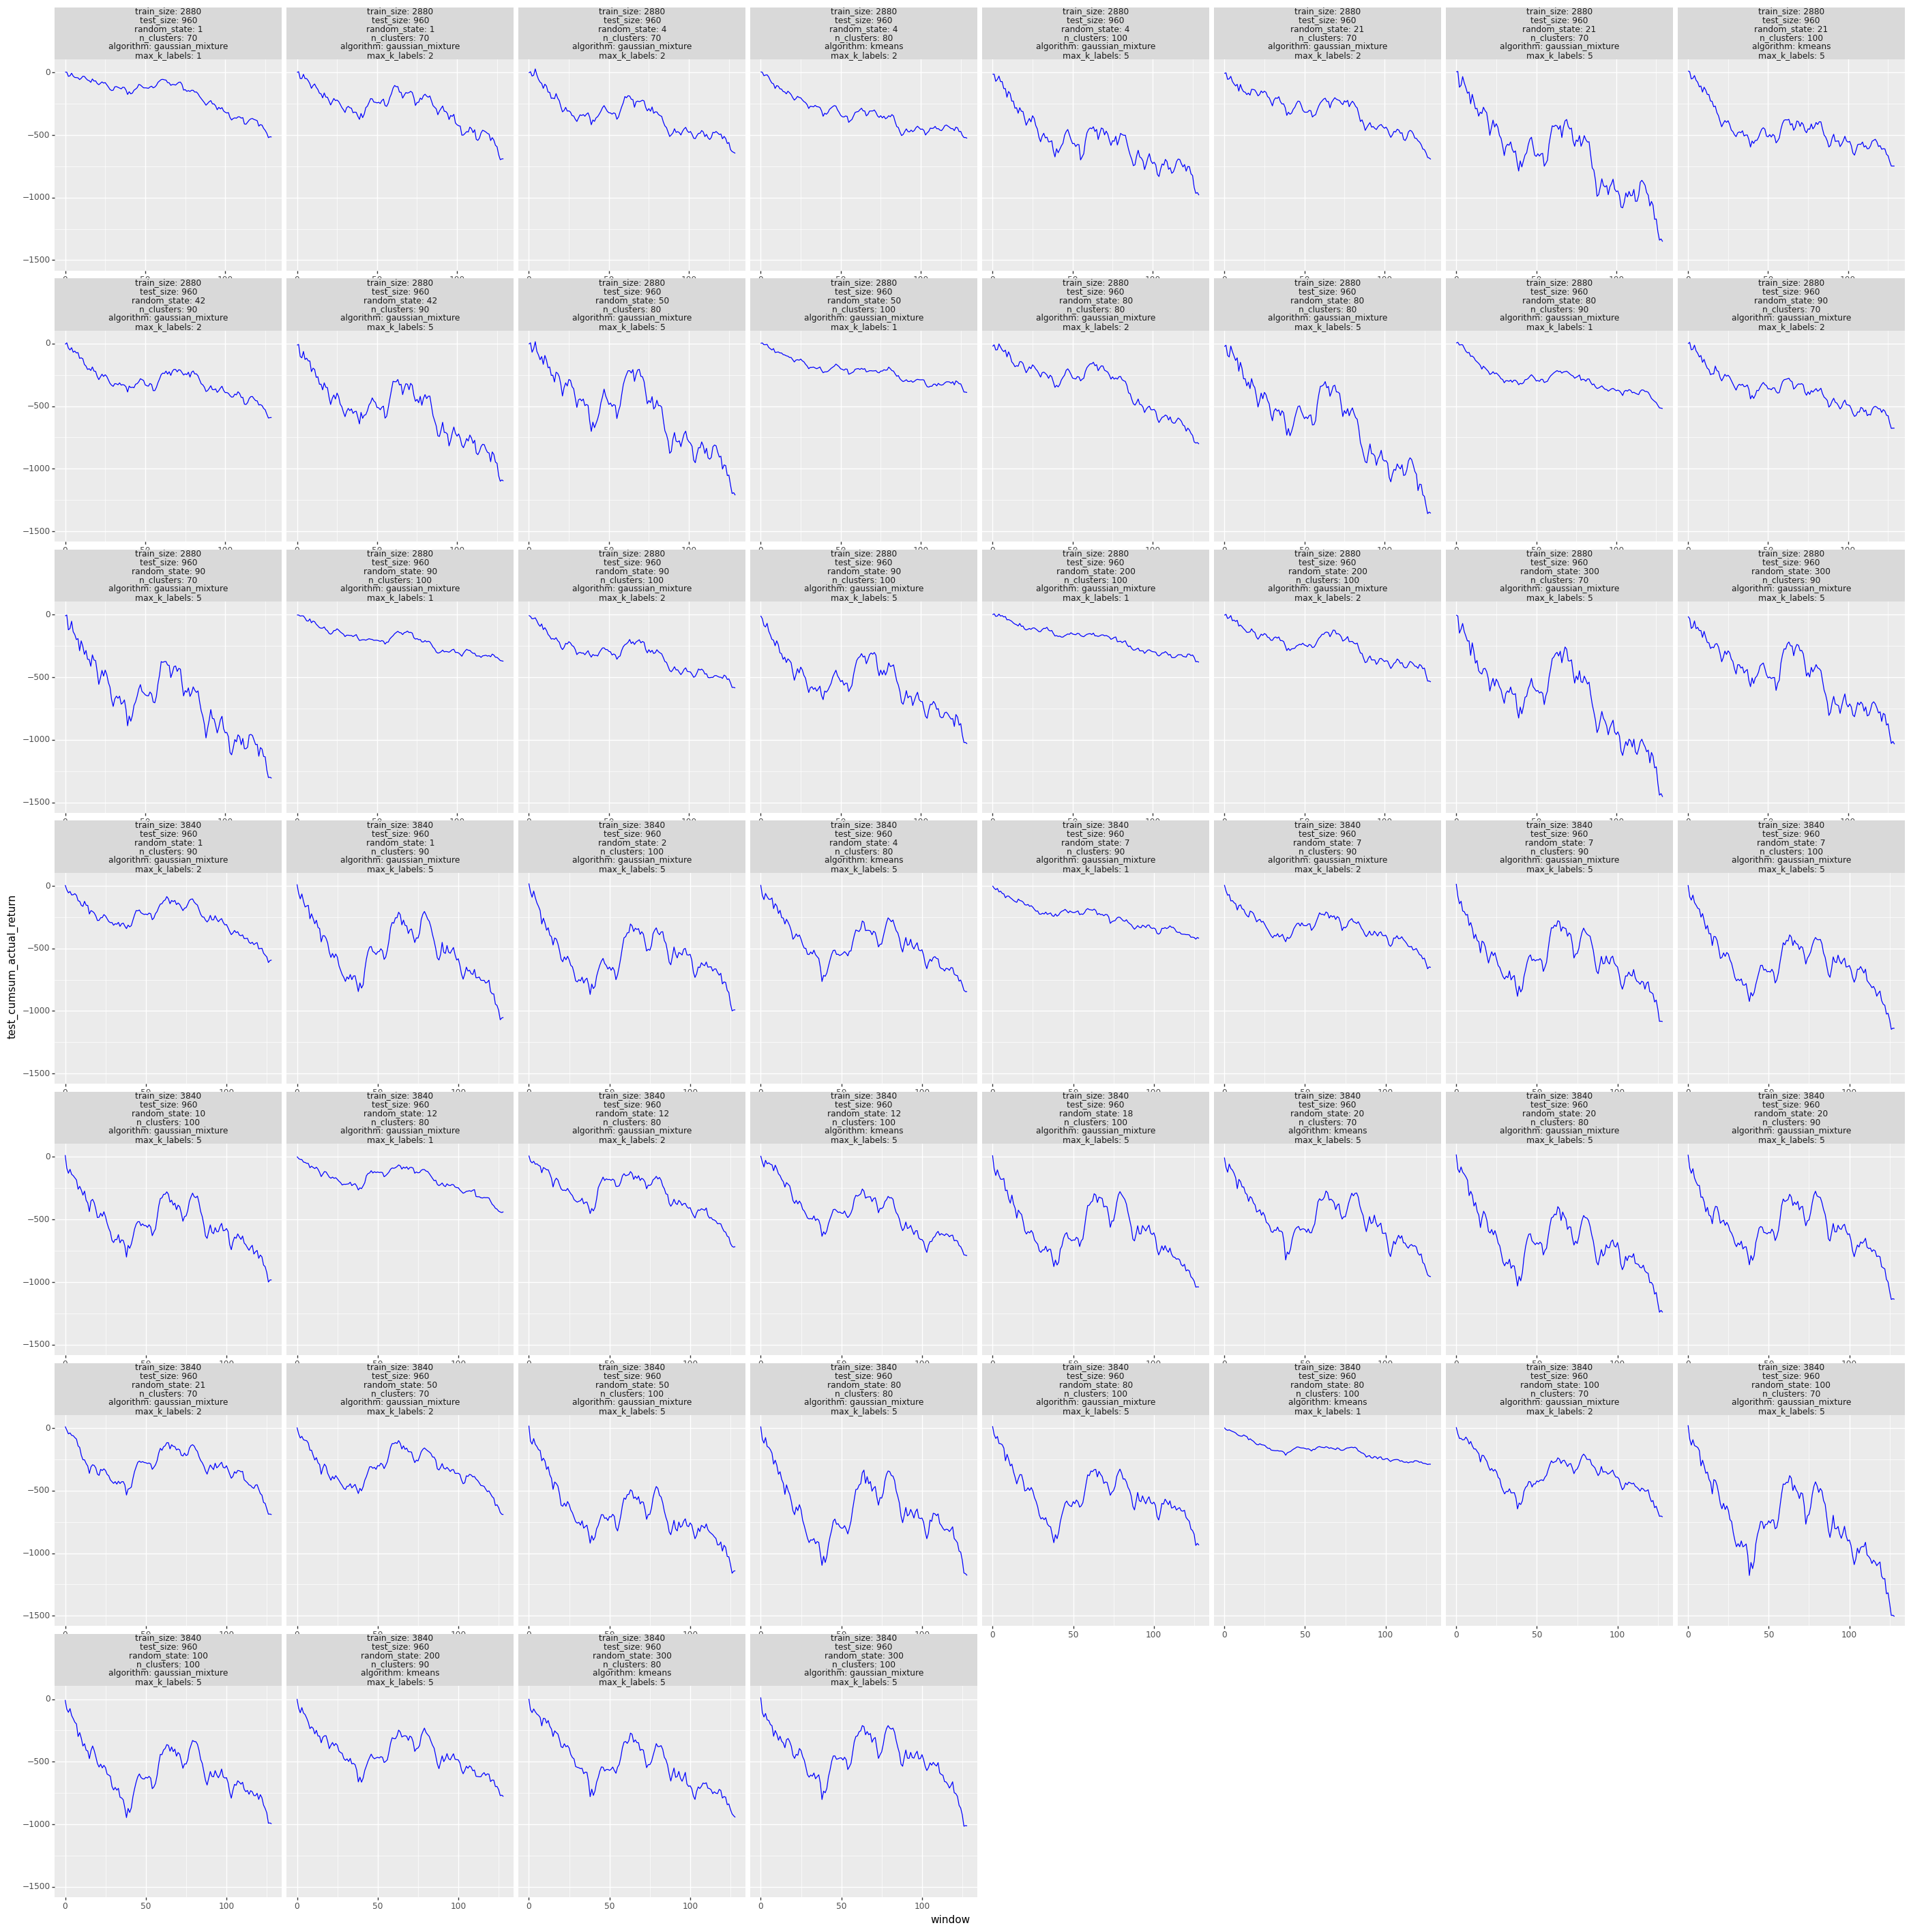

In [3]:
p = ggplot(df)
# p = p + geom_line(aes(x="window", y="train_cumsum_annualized_return"), color="red")
p = p + geom_line(aes(x="window", y="test_cumsum_actual_return"), color="blue")
# p = p + geom_line(aes(x="window", y="val_avg_calmar_ratio"), color="red")
# p = p + facet_wrap("~train_size + random_state", scales="free_x", labeller="label_both")
p = p + facet_wrap("~train_size + test_size + random_state + n_clusters + algorithm + max_k_labels", scales="free_x", labeller="label_both")
p = p + theme(figure_size=(35, 35))
# p = p + theme(figure_size=(10, 10))
print(p)

In [ ]:

time = "2024-03-14_19:00"
df = pd.read_csv(f"/projects/genomic-ml/da2343/ml_project_2/kmeans/results/{time}_results.csv")

p = ggplot(df)
p = p + geom_line(aes(x="window", y="test_cumsum_annualized_return"), color="blue")
# p = p + geom_line(aes(x="window", y="val_cumsum_annualized_return"), color="red")
p = p + facet_wrap("~train_size + test_size + random_state", scales="free_x", labeller="label_both")
p = p + theme(axis_text_x=element_text(angle=90), figure_size=(30, 30))
print(p)